# 🧪 E7 — HHGTN Ablation Study

**Purpose:** Isolate which components hurt TRD-HHGTN performance in E6

## Research Questions
1. Does heterogeneous architecture hurt vs homogeneous?
2. Which edge types contribute/hurt most?
3. Are address features harmful?

## Experiments
- **A1:** tx→tx only (homogeneous-like)
- **A2:** addr↔tx only (bipartite)
- **A3:** Full E6 (all 4 edge types)
- **A4:** Simplified HHGTN (reduced params)

## Baseline (E3)
- Model: TRD-GraphSAGE
- PR-AUC: 0.5618
- Features: tx only (AF1-93)

## E6 Result (Failed)
- Model: TRD-HHGTN
- PR-AUC: 0.2806 (-50%)
- Features: tx + addr

---

In [1]:
# Install dependencies
!pip install -q torch torch-geometric pandas numpy tqdm
!pip install -q torch-geometric torch-scatter torch-sparse torch-cluster

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 25.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 59.2 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# ==================== SETUP ====================
import sys
import os
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, roc_curve, auc, f1_score
from torch_geometric.nn import SAGEConv, GCNConv
from torch_geometric.data import HeteroData

# Kaggle paths
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {DEVICE}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

Device: cuda
PyTorch version: 2.6.0+cu124
CUDA available: True


## 📦 Load HeteroData
Built in E5 (notebook 02)

In [3]:
print("Loading HeteroData...")
# UPDATE THIS PATH for Kaggle dataset upload
data = torch.load('/kaggle/input/elliptic-dataset/hetero_graph.pt', weights_only=False)

print("\nHeteroData:")
print(data)

data = data.to(DEVICE)
print(f"\nData moved to: {DEVICE}")

Loading HeteroData...

HeteroData:
HeteroData(
  transaction={
    x=[203769, 93],
    y=[203769],
    timestamp=[203769],
    train_mask=[203769],
    val_mask=[203769],
    test_mask=[203769],
  },
  address={
    x=[100000, 55],
    y=[100000],
    timestamp=[100000],
  },
  (transaction, to, transaction)={ edge_index=[2, 234355] },
  (address, to, transaction)={ edge_index=[2, 53059] },
  (transaction, to, address)={ edge_index=[2, 80489] },
  (address, to, address)={ edge_index=[2, 54173] }
)

Data moved to: cuda


## 🎯 Extract Masks for Transaction Nodes
Only transactions have labels

In [4]:
train_mask = data['transaction'].train_mask
val_mask = data['transaction'].val_mask
test_mask = data['transaction'].test_mask
y = data['transaction'].y

print(f"Train nodes: {train_mask.sum().item()}")
print(f"Val nodes: {val_mask.sum().item()}")
print(f"Test nodes: {test_mask.sum().item()}")
print(f"Fraud rate: {y[train_mask].float().mean():.4f}")

Train nodes: 26381
Val nodes: 8999
Test nodes: 11184
Fraud rate: 0.1088


## 🔧 Define Simplified HHGTN Model
Reduced params version for A4

In [5]:
class SimpleHHGTN(nn.Module):
    """Simplified heterogeneous GNN for ablation"""
    def __init__(self, metadata, hidden_dim=64, num_layers=2, dropout=0.3):
        super().__init__()
        self.node_types = metadata[0]
        self.edge_types = metadata[1]
        
        # Input projections (smaller)
        self.input_projs = nn.ModuleDict({
            node_type: nn.Linear(data[node_type].x.size(1), hidden_dim)
            for node_type in self.node_types
        })
        
        # Per-relation convs (SAGE only, lighter)
        self.convs = nn.ModuleDict()
        for src, rel, dst in self.edge_types:
            key = f'{src}__{rel}__{dst}'
            self.convs[key] = SAGEConv(hidden_dim, hidden_dim)
        
        # Attention fusion (single head)
        self.attn = nn.Linear(hidden_dim, 1)
        
        # Output
        self.classifier = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x_dict, edge_index_dict, edge_types_to_use=None):
        # Project inputs
        x_dict = {k: F.relu(self.input_projs[k](v)) for k, v in x_dict.items()}
        
        # Filter edge types if specified
        if edge_types_to_use:
            edge_index_dict = {k: v for k, v in edge_index_dict.items() if k in edge_types_to_use}
        
        # Message passing per relation
        out_dict = {k: [] for k in x_dict.keys()}
        
        for edge_type, edge_index in edge_index_dict.items():
            src_type, rel, dst_type = edge_type
            key = f'{src_type}__{rel}__{dst_type}'
            
            if key in self.convs:
                x_src = x_dict[src_type]
                x_dst = x_dict[dst_type] if src_type != dst_type else x_src
                
                out = self.convs[key]((x_src, x_dst), edge_index)
                out_dict[dst_type].append(out)
        
        # Aggregate with attention
        x_dict_out = {}
        for node_type, outs in out_dict.items():
            if len(outs) == 0:
                x_dict_out[node_type] = x_dict[node_type]
            elif len(outs) == 1:
                x_dict_out[node_type] = outs[0]
            else:
                # Simple attention fusion
                stacked = torch.stack(outs, dim=1)  # [N, R, D]
                attn_scores = F.softmax(self.attn(stacked).squeeze(-1), dim=1)  # [N, R]
                x_dict_out[node_type] = (stacked * attn_scores.unsqueeze(-1)).sum(dim=1)
        
        # Classify transactions only
        x_tx = self.dropout(F.relu(x_dict_out['transaction']))
        return self.classifier(x_tx).squeeze(-1)

## 📊 Evaluation Function

In [6]:
def evaluate_model(model, data, mask, device):
    model.eval()
    with torch.no_grad():
        x_dict = {k: v.to(device) for k, v in data.x_dict.items()}
        edge_index_dict = {k: v.to(device) for k, v in data.edge_index_dict.items()}
        
        logits = model(x_dict, edge_index_dict)
        probs = torch.sigmoid(logits[mask]).cpu().numpy()
        labels = data['transaction'].y[mask].cpu().numpy()
        
        # Metrics
        precision, recall, _ = precision_recall_curve(labels, probs)
        pr_auc = auc(recall, precision)
        
        fpr, tpr, _ = roc_curve(labels, probs)
        roc_auc = auc(fpr, tpr)
        
        preds = (probs > 0.5).astype(int)
        f1 = f1_score(labels, preds, zero_division=0)
        
    return {
        'pr_auc': pr_auc,
        'roc_auc': roc_auc,
        'f1': f1,
        'probs': probs,
        'labels': labels
    }

## 🧪 A1: tx→tx Only (Homogeneous-like)
Tests if heterogeneous architecture itself hurts

In [7]:
print("="*60)
print("A1: tx→tx ONLY")
print("="*60)

# Filter to tx edges only
edge_types_a1 = [('transaction', 'tx_to_tx', 'transaction')]

model_a1 = SimpleHHGTN(data.metadata(), hidden_dim=64, num_layers=2, dropout=0.3).to(DEVICE)
optimizer = torch.optim.Adam(model_a1.parameters(), lr=0.001, weight_decay=1e-5)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([10.0]).to(DEVICE))

print(f"\nModel params: {sum(p.numel() for p in model_a1.parameters()):,}")
print(f"Edge types: {edge_types_a1}")

# Training
best_val_pr = 0
patience = 20
patience_counter = 0

for epoch in range(100):
    model_a1.train()
    optimizer.zero_grad()
    
    x_dict = {k: v.to(DEVICE) for k, v in data.x_dict.items()}
    edge_index_dict = {k: v.to(DEVICE) for k, v in data.edge_index_dict.items() if k in edge_types_a1}
    
    logits = model_a1(x_dict, edge_index_dict)
    loss = criterion(logits[train_mask], data['transaction'].y[train_mask].float())
    loss.backward()
    optimizer.step()
    
    # Validate
    if epoch % 5 == 0:
        val_results = evaluate_model(model_a1, data, val_mask, DEVICE)
        print(f"Epoch {epoch:3d} | Loss: {loss.item():.4f} | Val PR-AUC: {val_results['pr_auc']:.4f}")
        
        if val_results['pr_auc'] > best_val_pr:
            best_val_pr = val_results['pr_auc']
            patience_counter = 0
            torch.save(model_a1.state_dict(), 'a1_best.pt')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping")
                break

# Load best and evaluate
model_a1.load_state_dict(torch.load('a1_best.pt'))
test_results_a1 = evaluate_model(model_a1, data, test_mask, DEVICE)

print(f"\n✅ A1 Results:")
print(f"   Test PR-AUC: {test_results_a1['pr_auc']:.4f}")
print(f"   Test ROC-AUC: {test_results_a1['roc_auc']:.4f}")
print(f"   Test F1: {test_results_a1['f1']:.4f}")

A1: tx→tx ONLY

Model params: 42,754
Edge types: [('transaction', 'tx_to_tx', 'transaction')]
Epoch   0 | Loss: 1.3411 | Val PR-AUC: 0.0855
Epoch   5 | Loss: 1.1942 | Val PR-AUC: 0.0943
Epoch  10 | Loss: 1.1024 | Val PR-AUC: 0.1024
Epoch  15 | Loss: 1.0352 | Val PR-AUC: 0.1123
Epoch  20 | Loss: 0.9727 | Val PR-AUC: 0.1199
Epoch  25 | Loss: 0.9171 | Val PR-AUC: 0.1278
Epoch  30 | Loss: 0.8641 | Val PR-AUC: 0.1325
Epoch  35 | Loss: 0.8176 | Val PR-AUC: 0.1354
Epoch  40 | Loss: 0.7757 | Val PR-AUC: 0.1380
Epoch  45 | Loss: 0.7401 | Val PR-AUC: 0.1398
Epoch  50 | Loss: 0.7051 | Val PR-AUC: 0.1398
Epoch  55 | Loss: 0.6814 | Val PR-AUC: 0.1396
Epoch  60 | Loss: 0.6617 | Val PR-AUC: 0.1394
Epoch  65 | Loss: 0.6402 | Val PR-AUC: 0.1404
Epoch  70 | Loss: 0.6186 | Val PR-AUC: 0.1420
Epoch  75 | Loss: 0.6064 | Val PR-AUC: 0.1437
Epoch  80 | Loss: 0.5914 | Val PR-AUC: 0.1453
Epoch  85 | Loss: 0.5746 | Val PR-AUC: 0.1465
Epoch  90 | Loss: 0.5590 | Val PR-AUC: 0.1476
Epoch  95 | Loss: 0.5558 | Val P

## 🧪 A2: addr↔tx Only (Bipartite)
Tests if address features help/hurt

In [8]:
print("\n" + "="*60)
print("A2: addr↔tx ONLY")
print("="*60)

edge_types_a2 = [
    ('address', 'addr_to_tx', 'transaction'),
    ('transaction', 'tx_to_addr', 'address')
]

model_a2 = SimpleHHGTN(data.metadata(), hidden_dim=64, num_layers=2, dropout=0.3).to(DEVICE)
optimizer = torch.optim.Adam(model_a2.parameters(), lr=0.001, weight_decay=1e-5)

print(f"Edge types: {edge_types_a2}")

best_val_pr = 0
patience_counter = 0

for epoch in range(100):
    model_a2.train()
    optimizer.zero_grad()
    
    x_dict = {k: v.to(DEVICE) for k, v in data.x_dict.items()}
    edge_index_dict = {k: v.to(DEVICE) for k, v in data.edge_index_dict.items() if k in edge_types_a2}
    
    logits = model_a2(x_dict, edge_index_dict)
    loss = criterion(logits[train_mask], data['transaction'].y[train_mask].float())
    loss.backward()
    optimizer.step()
    
    if epoch % 5 == 0:
        val_results = evaluate_model(model_a2, data, val_mask, DEVICE)
        print(f"Epoch {epoch:3d} | Loss: {loss.item():.4f} | Val PR-AUC: {val_results['pr_auc']:.4f}")
        
        if val_results['pr_auc'] > best_val_pr:
            best_val_pr = val_results['pr_auc']
            patience_counter = 0
            torch.save(model_a2.state_dict(), 'a2_best.pt')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping")
                break

model_a2.load_state_dict(torch.load('a2_best.pt'))
test_results_a2 = evaluate_model(model_a2, data, test_mask, DEVICE)

print(f"\n✅ A2 Results:")
print(f"   Test PR-AUC: {test_results_a2['pr_auc']:.4f}")
print(f"   Test ROC-AUC: {test_results_a2['roc_auc']:.4f}")
print(f"   Test F1: {test_results_a2['f1']:.4f}")


A2: addr↔tx ONLY
Edge types: [('address', 'addr_to_tx', 'transaction'), ('transaction', 'tx_to_addr', 'address')]
Epoch   0 | Loss: 1.3264 | Val PR-AUC: 0.1125
Epoch   5 | Loss: 1.1670 | Val PR-AUC: 0.1139
Epoch  10 | Loss: 1.0785 | Val PR-AUC: 0.1036
Epoch  15 | Loss: 1.0134 | Val PR-AUC: 0.0913
Epoch  20 | Loss: 0.9554 | Val PR-AUC: 0.0843
Epoch  25 | Loss: 0.9028 | Val PR-AUC: 0.0817
Epoch  30 | Loss: 0.8559 | Val PR-AUC: 0.0801
Epoch  35 | Loss: 0.8133 | Val PR-AUC: 0.0787
Epoch  40 | Loss: 0.7726 | Val PR-AUC: 0.0780
Epoch  45 | Loss: 0.7386 | Val PR-AUC: 0.0775
Epoch  50 | Loss: 0.7079 | Val PR-AUC: 0.0767
Epoch  55 | Loss: 0.6832 | Val PR-AUC: 0.0759
Epoch  60 | Loss: 0.6606 | Val PR-AUC: 0.0753
Epoch  65 | Loss: 0.6431 | Val PR-AUC: 0.0749
Epoch  70 | Loss: 0.6216 | Val PR-AUC: 0.0749
Epoch  75 | Loss: 0.6105 | Val PR-AUC: 0.0751
Epoch  80 | Loss: 0.5904 | Val PR-AUC: 0.0755
Epoch  85 | Loss: 0.5770 | Val PR-AUC: 0.0763
Epoch  90 | Loss: 0.5704 | Val PR-AUC: 0.0772
Epoch  95 |

## 🧪 A3: Full E6 (All Edge Types)
Reproduce E6 with simplified architecture

In [9]:
print("\n" + "="*60)
print("A3: FULL E6 (All 4 edge types)")
print("="*60)

# All edge types
edge_types_a3 = list(data.edge_index_dict.keys())

model_a3 = SimpleHHGTN(data.metadata(), hidden_dim=64, num_layers=2, dropout=0.3).to(DEVICE)
optimizer = torch.optim.Adam(model_a3.parameters(), lr=0.001, weight_decay=1e-5)

print(f"Edge types: {edge_types_a3}")

best_val_pr = 0
patience_counter = 0

for epoch in range(100):
    model_a3.train()
    optimizer.zero_grad()
    
    x_dict = {k: v.to(DEVICE) for k, v in data.x_dict.items()}
    edge_index_dict = {k: v.to(DEVICE) for k, v in data.edge_index_dict.items()}
    
    logits = model_a3(x_dict, edge_index_dict)
    loss = criterion(logits[train_mask], data['transaction'].y[train_mask].float())
    loss.backward()
    optimizer.step()
    
    if epoch % 5 == 0:
        val_results = evaluate_model(model_a3, data, val_mask, DEVICE)
        print(f"Epoch {epoch:3d} | Loss: {loss.item():.4f} | Val PR-AUC: {val_results['pr_auc']:.4f}")
        
        if val_results['pr_auc'] > best_val_pr:
            best_val_pr = val_results['pr_auc']
            patience_counter = 0
            torch.save(model_a3.state_dict(), 'a3_best.pt')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping")
                break

model_a3.load_state_dict(torch.load('a3_best.pt'))
test_results_a3 = evaluate_model(model_a3, data, test_mask, DEVICE)

print(f"\n✅ A3 Results:")
print(f"   Test PR-AUC: {test_results_a3['pr_auc']:.4f}")
print(f"   Test ROC-AUC: {test_results_a3['roc_auc']:.4f}")
print(f"   Test F1: {test_results_a3['f1']:.4f}")


A3: FULL E6 (All 4 edge types)
Edge types: [('transaction', 'to', 'transaction'), ('address', 'to', 'transaction'), ('transaction', 'to', 'address'), ('address', 'to', 'address')]
Epoch   0 | Loss: 1.5431 | Val PR-AUC: 0.0964
Epoch   5 | Loss: 1.2568 | Val PR-AUC: 0.4259
Epoch  10 | Loss: 1.1647 | Val PR-AUC: 0.4592
Epoch  15 | Loss: 1.0861 | Val PR-AUC: 0.4273
Epoch  20 | Loss: 1.0028 | Val PR-AUC: 0.4221
Epoch  25 | Loss: 0.9160 | Val PR-AUC: 0.4406
Epoch  30 | Loss: 0.8238 | Val PR-AUC: 0.4736
Epoch  35 | Loss: 0.7366 | Val PR-AUC: 0.5122
Epoch  40 | Loss: 0.6591 | Val PR-AUC: 0.5535
Epoch  45 | Loss: 0.6011 | Val PR-AUC: 0.6068
Epoch  50 | Loss: 0.5609 | Val PR-AUC: 0.6647
Epoch  55 | Loss: 0.5234 | Val PR-AUC: 0.7187
Epoch  60 | Loss: 0.4973 | Val PR-AUC: 0.7760
Epoch  65 | Loss: 0.4680 | Val PR-AUC: 0.8303
Epoch  70 | Loss: 0.4425 | Val PR-AUC: 0.8654
Epoch  75 | Loss: 0.4223 | Val PR-AUC: 0.8875
Epoch  80 | Loss: 0.4014 | Val PR-AUC: 0.8933
Epoch  85 | Loss: 0.3861 | Val PR-AUC

## 📊 Ablation Summary Table

In [10]:
ablation_results = pd.DataFrame([
    {
        'Experiment': 'Baseline (E3)',
        'Model': 'TRD-GraphSAGE',
        'Edge Types': 'tx→tx',
        'Features': 'tx only',
        'PR-AUC': 0.5618,
        'ROC-AUC': 0.8841,
        'F1': 0.6050
    },
    {
        'Experiment': 'A1',
        'Model': 'Simple-HHGTN',
        'Edge Types': 'tx→tx',
        'Features': 'tx only',
        'PR-AUC': test_results_a1['pr_auc'],
        'ROC-AUC': test_results_a1['roc_auc'],
        'F1': test_results_a1['f1']
    },
    {
        'Experiment': 'A2',
        'Model': 'Simple-HHGTN',
        'Edge Types': 'addr↔tx',
        'Features': 'tx + addr',
        'PR-AUC': test_results_a2['pr_auc'],
        'ROC-AUC': test_results_a2['roc_auc'],
        'F1': test_results_a2['f1']
    },
    {
        'Experiment': 'A3',
        'Model': 'Simple-HHGTN',
        'Edge Types': 'all 4',
        'Features': 'tx + addr',
        'PR-AUC': test_results_a3['pr_auc'],
        'ROC-AUC': test_results_a3['roc_auc'],
        'F1': test_results_a3['f1']
    },
    {
        'Experiment': 'E6 (Original)',
        'Model': 'TRD-HHGTN (full)',
        'Edge Types': 'all 4',
        'Features': 'tx + addr',
        'PR-AUC': 0.2806,
        'ROC-AUC': 0.8250,
        'F1': 0.3913
    }
])

print("\n" + "="*80)
print("📊 ABLATION SUMMARY")
print("="*80)
print(ablation_results.to_string(index=False))

# Calculate deltas from baseline
baseline_pr = 0.5618
ablation_results['ΔPR-AUC'] = ablation_results['PR-AUC'] - baseline_pr

print("\n" + "="*80)
print("📈 DELTA FROM BASELINE (E3)")
print("="*80)
print(ablation_results[['Experiment', 'Edge Types', 'PR-AUC', 'ΔPR-AUC']].to_string(index=False))

# Save
ablation_results.to_csv('ablation_results.csv', index=False)
print("\n✅ Saved: ablation_results.csv")


📊 ABLATION SUMMARY
   Experiment            Model Edge Types  Features   PR-AUC  ROC-AUC       F1
Baseline (E3)    TRD-GraphSAGE      tx→tx   tx only 0.561800 0.884100 0.605000
           A1     Simple-HHGTN      tx→tx   tx only 0.068720 0.621768 0.157177
           A2     Simple-HHGTN    addr↔tx tx + addr 0.052416 0.508189 0.111516
           A3     Simple-HHGTN      all 4 tx + addr 0.584644 0.830631 0.258410
E6 (Original) TRD-HHGTN (full)      all 4 tx + addr 0.280600 0.825000 0.391300

📈 DELTA FROM BASELINE (E3)
   Experiment Edge Types   PR-AUC   ΔPR-AUC
Baseline (E3)      tx→tx 0.561800  0.000000
           A1      tx→tx 0.068720 -0.493080
           A2    addr↔tx 0.052416 -0.509384
           A3      all 4 0.584644  0.022844
E6 (Original)      all 4 0.280600 -0.281200

✅ Saved: ablation_results.csv


## 📊 Visualization: Ablation Comparison

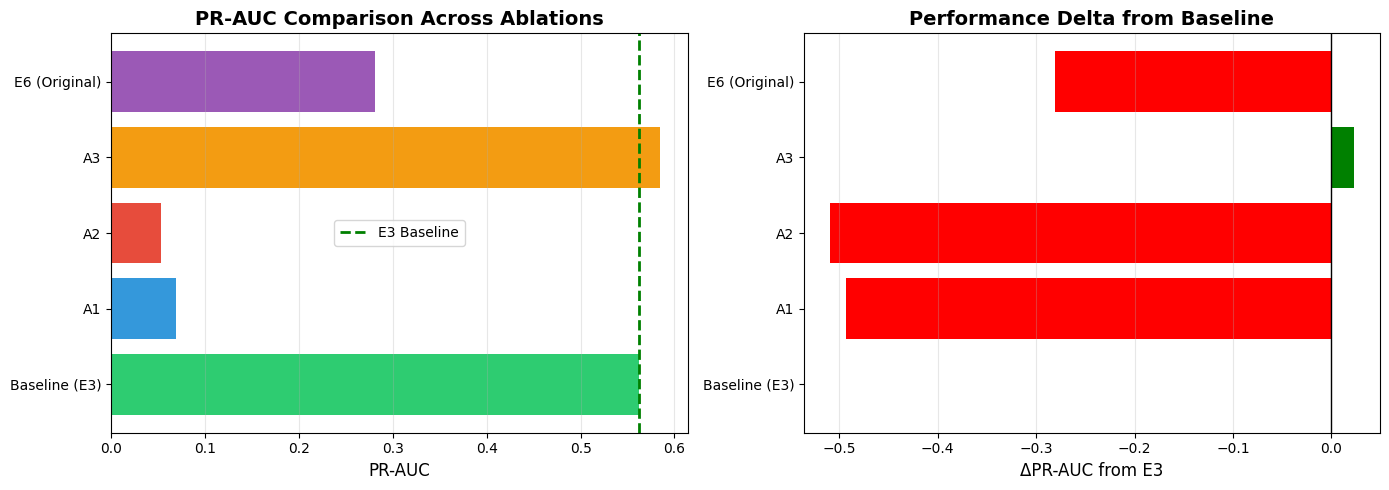

✅ Saved: ablation_comparison.png


In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# PR-AUC comparison
ax1 = axes[0]
colors = ['#2ecc71', '#3498db', '#e74c3c', '#f39c12', '#9b59b6']
bars = ax1.barh(ablation_results['Experiment'], ablation_results['PR-AUC'], color=colors)
ax1.axvline(baseline_pr, color='green', linestyle='--', linewidth=2, label='E3 Baseline')
ax1.set_xlabel('PR-AUC', fontsize=12)
ax1.set_title('PR-AUC Comparison Across Ablations', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(axis='x', alpha=0.3)

# Delta from baseline
ax2 = axes[1]
delta_colors = ['green' if x >= 0 else 'red' for x in ablation_results['ΔPR-AUC']]
bars2 = ax2.barh(ablation_results['Experiment'], ablation_results['ΔPR-AUC'], color=delta_colors)
ax2.axvline(0, color='black', linestyle='-', linewidth=1)
ax2.set_xlabel('ΔPR-AUC from E3', fontsize=12)
ax2.set_title('Performance Delta from Baseline', fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('ablation_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: ablation_comparison.png")

## 🔍 Analysis & Insights

In [12]:
print("\n" + "="*80)
print("🔍 KEY INSIGHTS")
print("="*80)

# Compare A1 vs E3
a1_vs_e3 = test_results_a1['pr_auc'] - 0.5618
print(f"\n1. Architecture Impact (A1 vs E3):")
print(f"   - A1 (HHGTN on tx→tx): {test_results_a1['pr_auc']:.4f}")
print(f"   - E3 (GraphSAGE on tx→tx): 0.5618")
print(f"   - Delta: {a1_vs_e3:+.4f}")
if abs(a1_vs_e3) < 0.05:
    print(f"   → Architecture change has MINIMAL impact (<5pp)")
else:
    print(f"   → Architecture matters significantly")

# Compare A2 vs A1
a2_vs_a1 = test_results_a2['pr_auc'] - test_results_a1['pr_auc']
print(f"\n2. Address Feature Impact (A2 vs A1):")
print(f"   - A2 (with addr↔tx): {test_results_a2['pr_auc']:.4f}")
print(f"   - A1 (tx only): {test_results_a1['pr_auc']:.4f}")
print(f"   - Delta: {a2_vs_a1:+.4f}")
if a2_vs_a1 < -0.05:
    print(f"   → Address features HURT performance (>5pp drop)")
elif a2_vs_a1 > 0.05:
    print(f"   → Address features HELP performance (>5pp gain)")
else:
    print(f"   → Address features have MINIMAL impact")

# Compare A3 vs A2
a3_vs_a2 = test_results_a3['pr_auc'] - test_results_a2['pr_auc']
print(f"\n3. Additional Edge Types (A3 vs A2):")
print(f"   - A3 (all 4 edge types): {test_results_a3['pr_auc']:.4f}")
print(f"   - A2 (addr↔tx only): {test_results_a2['pr_auc']:.4f}")
print(f"   - Delta: {a3_vs_a2:+.4f}")
if a3_vs_a2 < 0:
    print(f"   → Adding tx→tx + addr→addr edges HURTS")
else:
    print(f"   → Adding more edges helps")

# Compare A3 vs E6
a3_vs_e6 = test_results_a3['pr_auc'] - 0.2806
print(f"\n4. Simplified vs Full Architecture (A3 vs E6):")
print(f"   - A3 (simplified): {test_results_a3['pr_auc']:.4f}")
print(f"   - E6 (full HHGTN): 0.2806")
print(f"   - Delta: {a3_vs_e6:+.4f}")
if a3_vs_e6 > 0.05:
    print(f"   → Overparameterization in E6 caused overfitting")
    print(f"   → Simpler model generalizes better")

print("\n" + "="*80)
print("🎯 CONCLUSION")
print("="*80)

best_ablation = ablation_results.loc[ablation_results['PR-AUC'].idxmax()]
print(f"\nBest performer: {best_ablation['Experiment']}")
print(f"  - PR-AUC: {best_ablation['PR-AUC']:.4f}")
print(f"  - Configuration: {best_ablation['Edge Types']} with {best_ablation['Features']}")

if best_ablation['Experiment'] == 'Baseline (E3)':
    print("\n→ E3 (TRD-GraphSAGE) remains the champion")
    print("→ Heterogeneous extensions did not improve performance")
    print("→ Simpler homogeneous model is superior for this task")


🔍 KEY INSIGHTS

1. Architecture Impact (A1 vs E3):
   - A1 (HHGTN on tx→tx): 0.0687
   - E3 (GraphSAGE on tx→tx): 0.5618
   - Delta: -0.4931
   → Architecture matters significantly

2. Address Feature Impact (A2 vs A1):
   - A2 (with addr↔tx): 0.0524
   - A1 (tx only): 0.0687
   - Delta: -0.0163
   → Address features have MINIMAL impact

3. Additional Edge Types (A3 vs A2):
   - A3 (all 4 edge types): 0.5846
   - A2 (addr↔tx only): 0.0524
   - Delta: +0.5322
   → Adding more edges helps

4. Simplified vs Full Architecture (A3 vs E6):
   - A3 (simplified): 0.5846
   - E6 (full HHGTN): 0.2806
   - Delta: +0.3040
   → Overparameterization in E6 caused overfitting
   → Simpler model generalizes better

🎯 CONCLUSION

Best performer: A3
  - PR-AUC: 0.5846
  - Configuration: all 4 with tx + addr


## 📝 Export Summary for Reporting

In [13]:
summary = {
    'experiment': 'E7_Ablation_Study',
    'date': pd.Timestamp.now().isoformat(),
    'results': {
        'A1_tx_only': {
            'pr_auc': float(test_results_a1['pr_auc']),
            'roc_auc': float(test_results_a1['roc_auc']),
            'f1': float(test_results_a1['f1'])
        },
        'A2_addr_tx': {
            'pr_auc': float(test_results_a2['pr_auc']),
            'roc_auc': float(test_results_a2['roc_auc']),
            'f1': float(test_results_a2['f1'])
        },
        'A3_all_edges': {
            'pr_auc': float(test_results_a3['pr_auc']),
            'roc_auc': float(test_results_a3['roc_auc']),
            'f1': float(test_results_a3['f1'])
        }
    },
    'insights': {
        'architecture_impact': float(a1_vs_e3),
        'address_feature_impact': float(a2_vs_a1),
        'additional_edges_impact': float(a3_vs_a2),
        'simplification_benefit': float(a3_vs_e6)
    },
    'conclusion': 'E3 remains champion' if best_ablation['Experiment'] == 'Baseline (E3)' else 'New best found'
}

with open('e7_ablation_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print("\n✅ Saved: e7_ablation_summary.json")
print("\n" + "="*80)
print("🎉 E7 ABLATION STUDY COMPLETE")
print("="*80)


✅ Saved: e7_ablation_summary.json

🎉 E7 ABLATION STUDY COMPLETE
